https://github.com/harveyslash/Facial-Similarity-with-Siamese-Networks-in-Pytorch

In [1]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [2]:
%matplotlib inline
import random
import matplotlib.pyplot as plt
from PIL import Image
import PIL.ImageOps    
from tqdm.auto import tqdm
import itertools

import numpy as np
import pandas as pd

import torch
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import torchvision.utils
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

from transformers import AutoImageProcessor, ResNetForImageClassification

# Configuration Class

In [3]:
class Config():
    training_dir = "data/att_faces/Training"
    testing_dir = "data/att_faces/Testing"
    train_batch_size = 64
    train_number_epochs = 100
    image_mean = np.array([0.485, 0.456, 0.406 ])
    image_std = np.array([0.229, 0.224, 0.225])
    save_freq = 100
    save_prefix = "runs/att_ConstrastiveLoss_Stages-2"
    resume_path = "runs/att_ContrastiveLoss/epochs_100.pth"
    save_path = save_prefix+"/epochs_100.pth"


# Helper functions
Set of helper functions

In [4]:
def imshow(img,text=None,should_save=False):
    npimg = np.asarray(img)#.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    # npimg = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg)
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [5]:
def prep_images(img_path, transform=None):
    img = Image.open(img_path).convert("RGB")

    if transform:
        img = transform(img)
        
    return img

# Model

In [6]:
class LearnedLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self):
        super(LearnedLoss, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(inplace=True),
            
            nn.Linear(64, 64),
            nn.ReLU(inplace=True),

            nn.Linear(64, 2)
        )
        self.ce_loss = nn.CrossEntropyLoss()
        
    def forward(self, output1, output2, label):
        label = label.to(torch.int64)
        output = torch.cat((output1,output2),dim=1)
        output = self.fc(output)
        return self.ce_loss(output, label)
    
    

In [7]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = False)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [8]:
class SiameseNetwork(nn.Module):
    def __init__(self, model_path = "microsoft/resnet-50"):
        super(SiameseNetwork, self).__init__()
        self.cnn = ResNetForImageClassification.from_pretrained(model_path).resnet

        for param in self.cnn.embedder.parameters():
            param.requires_grad_(False);
        self.cnn.embedder.eval()
            
        for i in range(3):
            for param in self.cnn.encoder.stages[i].parameters():
                param.requires_grad_(False);
            self.cnn.encoder.stages[i].eval()
            
        for i in range(2):
            for param in self.cnn.encoder.stages[3].layers[i].parameters():
                param.requires_grad_(False);
            self.cnn.encoder.stages[3].layers[i].eval()
            
        self.fc1 = nn.Sequential(
            nn.Linear(2048, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 32))

    def forward_once(self, x):
        output = self.cnn(x).pooler_output
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

# Dataset
Custom Dataset Class

This dataset generates a pair of images. 0 for geniune pair and 1 for imposter pair


In [9]:

class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None,should_invert=False):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
        images, ids = list(zip(*self.imageFolderDataset.imgs))        
        self.data_df = pd.DataFrame({'img':images, 'ids':ids})
        
    def __getitem__(self,index):
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            id_img = random.choice(self.data_df.ids.unique())
            df = self.data_df[self.data_df.ids==id_img].sample(n=2).reset_index(drop = True)
        else:
            id_img1, id_img2 = random.sample(self.data_df.ids.unique().tolist(),2)
            df1 = self.data_df[self.data_df.ids==id_img1].sample(n=1)
            df2 = self.data_df[self.data_df.ids==id_img2].sample(n=1)
            df = pd.concat([df1, df2]).reset_index(drop = True)

        img0 = Image.open(df.iloc[0].img).convert("RGB")
        img1 = Image.open(df.iloc[1].img).convert("RGB")
        # img0 = img0.convert("L")
        # img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return (df.iloc[0].img,img0), (df.iloc[1].img,img1) , torch.from_numpy(np.array(1-int(should_get_same_class),dtype=np.float32))
    
    def __len__(self):
        return 2*len(self.imageFolderDataset.imgs)
    

# Data Visualization

In [10]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [11]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(
                                    mean=Config.image_mean,
                                    std=Config.image_std)])
inv_normalize = transforms.Normalize(
    mean=-Config.image_mean/Config.image_std,
    std=1/Config.image_std
)

In [12]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset, transform = transform,should_invert=False)

In [13]:
x = siamese_dataset[2]

tensor(0.)

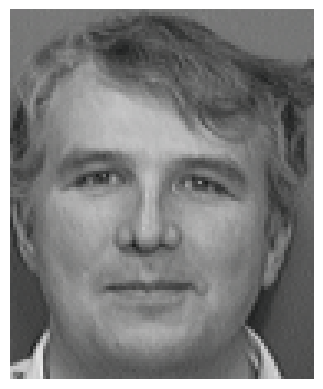

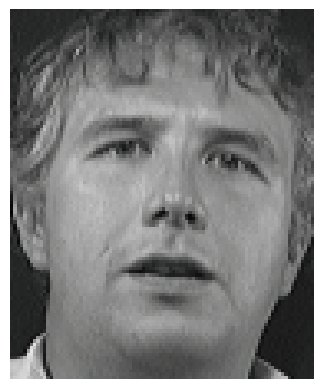

In [14]:
x[2]
imshow(inv_normalize(x[0][1]).permute(1,2,0))
imshow(inv_normalize(x[1][1]).permute(1,2,0))

# Training

In [15]:
device = "cuda:0"

In [16]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        pin_memory=False,
                        num_workers=0,
                        batch_size=Config.train_batch_size)

In [18]:
net = SiameseNetwork().to(device)

In [19]:
net.load_state_dict(torch.load(Config.resume_path))

<All keys matched successfully>

In [20]:
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )
# criterion = LearnedLoss().to(device)
# optimizer = optim.Adam(itertools.chain.from_iterable([net.parameters(), criterion.parameters()]),lr = 0.0005 )

In [21]:
writer = SummaryWriter(Config.save_prefix)

net.train()

pbar = tqdm(train_dataloader)
for epoch in range(0,Config.train_number_epochs):
    epoch_loss = 0
    running_loss = 0
    for i, data in enumerate(pbar):
        (_,img0), (_,img1), label = data
        img0, img1 , label = img0.to(device), img1.to(device) , label.to(device)
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        
        running_loss += loss_contrastive.item()
        if (i+1) %Config.save_freq == 0 :
            writer.add_scalar('training loss', running_loss/Config.save_freq, epoch * len(train_dataloader) + (i+1)/Config.save_freq)
            epoch_loss += running_loss
            running_loss = 0
    epoch_loss += running_loss
    print(f"Epoch {epoch}: loss : {epoch_loss/len(train_dataloader):.2f}")
    pbar.set_description(f"Epoch {epoch}: loss : {epoch_loss/len(train_dataloader):.5f}")
    pbar.update()
writer.close()

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 0: loss : 0.00
Epoch 1: loss : 0.00
Epoch 2: loss : 0.00
Epoch 3: loss : 0.00
Epoch 4: loss : 0.00
Epoch 5: loss : 0.00
Epoch 6: loss : 0.00
Epoch 7: loss : 0.00
Epoch 8: loss : 0.00
Epoch 9: loss : 0.00
Epoch 10: loss : 0.00
Epoch 11: loss : 0.00
Epoch 12: loss : 0.00
Epoch 13: loss : 0.00
Epoch 14: loss : 0.00
Epoch 15: loss : 0.00
Epoch 16: loss : 0.00
Epoch 17: loss : 0.00
Epoch 18: loss : 0.00
Epoch 19: loss : 0.00
Epoch 20: loss : 0.00
Epoch 21: loss : 0.00
Epoch 22: loss : 0.00
Epoch 23: loss : 0.00
Epoch 24: loss : 0.00
Epoch 25: loss : 0.00
Epoch 26: loss : 0.00
Epoch 27: loss : 0.00
Epoch 28: loss : 0.00
Epoch 29: loss : 0.00
Epoch 30: loss : 0.00
Epoch 31: loss : 0.00
Epoch 32: loss : 0.00
Epoch 33: loss : 0.00
Epoch 34: loss : 0.00
Epoch 35: loss : 0.00
Epoch 36: loss : 0.00
Epoch 37: loss : 0.00
Epoch 38: loss : 0.00
Epoch 39: loss : 0.00
Epoch 40: loss : 0.00
Epoch 41: loss : 0.00
Epoch 42: loss : 0.00
Epoch 43: loss : 0.00
Epoch 44: loss : 0.00
Epoch 45: loss : 0.0

In [ ]:
torch.save(net.state_dict(), Config.save_path)

In [ ]:
torch.save(criterion.state_dict(), Config.save_prefix+'/learned_loss.pth')

# Evaluate

In [114]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)

In [70]:
num_same_id = 4
num_diff_id = 8
images, ids = list(zip(*folder_dataset_test.imgs))    
df = pd.DataFrame({'img':images, 'ids':ids})
img0 = df.sample(n=1)

In [71]:
images, ids = list(zip(*folder_dataset_test.imgs))    
df = pd.DataFrame({'img':images, 'ids':ids})
img0 = df.sample(n=1)

In [72]:
test_id = img0.iloc[0].ids
test_img = img0.iloc[0].img

In [73]:
df_test = pd.concat([df[df.ids == test_id].sample(n=num_same_id), df[df.ids != test_id].sample(n=num_diff_id)])

In [74]:
x0 = prep_images(test_img, transform=transform)[None, :]

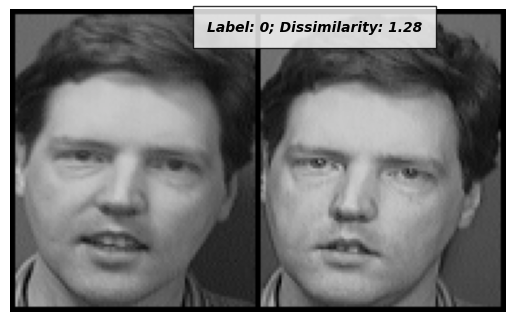

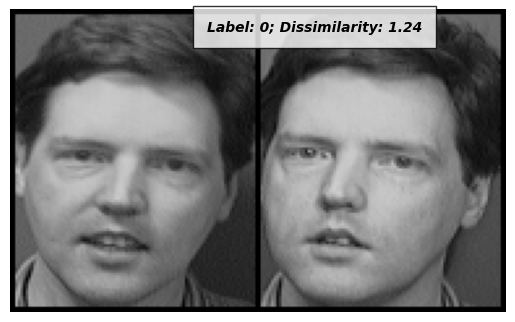

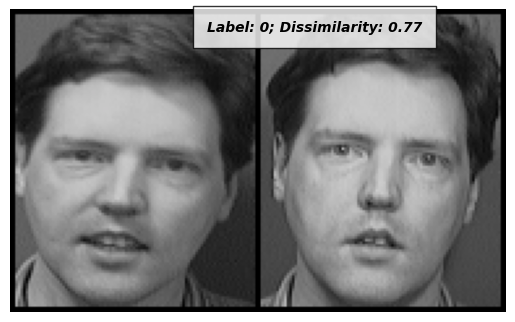

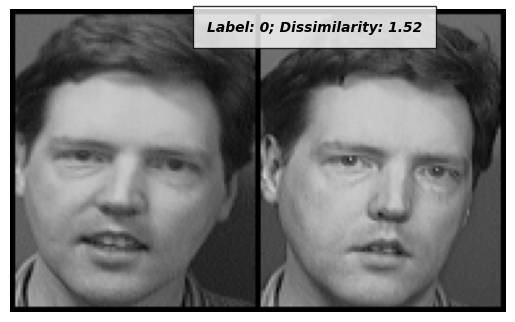

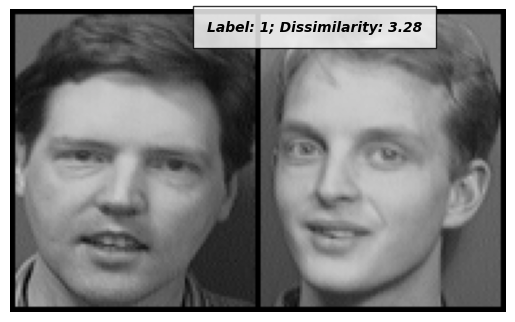

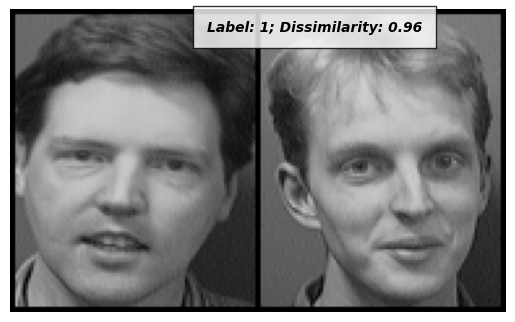

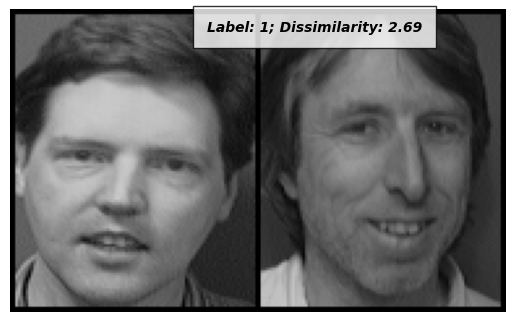

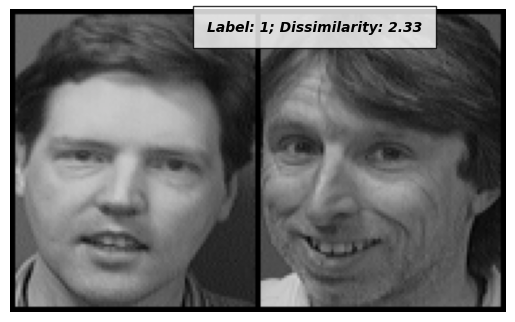

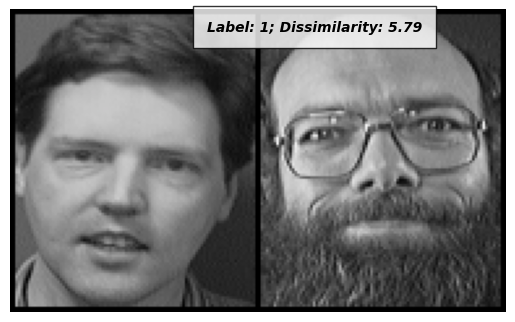

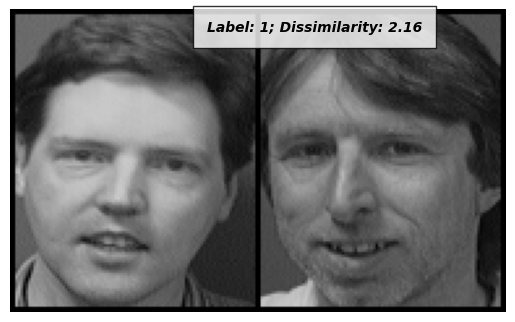

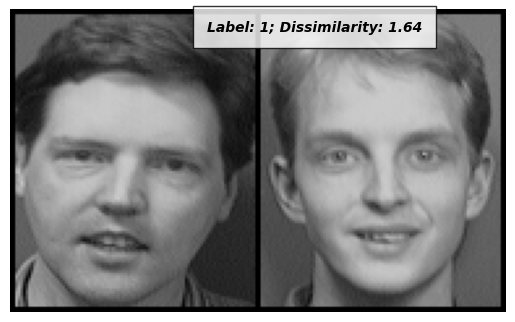

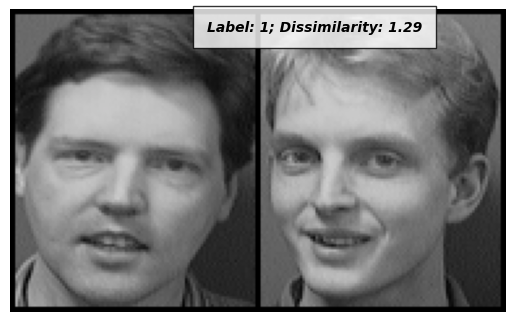

In [75]:
# loss_fn = ContrastiveLoss()
for i in range(len(df_test)):
    x1 = prep_images(df_test.iloc[i].img, transform=transform)[None, :]
    label = torch.tensor([int(df_test.iloc[i].ids != test_id)]).to(device)

    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(x0.to(device),x1.to(device))
    # euclidean_distance = criterion(output1, output2,label)
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(inv_normalize(concatenated)).permute(1,2,0),f'Label: {label[0].item()}; Dissimilarity: {euclidean_distance.item():.2f}')

# Loss

In [115]:
siamese_dataset_test = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test, transform = transform,should_invert=False)

In [116]:
test_dataloader = DataLoader(siamese_dataset_test,
                        shuffle=False,
                        pin_memory=False,
                        num_workers=0,
                        batch_size=1)#Config.train_batch_size)

In [117]:
net.eval();

In [118]:
total_loss = 0
with torch.no_grad():
    for data in test_dataloader:
        (_,img0), (_,img1), label = data
        img0, img1 , label = img0.to(device), img1.to(device) , label.to(device)
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        total_loss += loss_contrastive.item()

print("loss: {:.2f}".format(total_loss/len(test_dataloader)))

loss: 0.38
